In [1]:
#IMPORTS
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import SimpleRNN, Dense # type: ignore
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from typing import Tuple, List
from pathlib import Path
from sklearn.model_selection import train_test_split
import seaborn as sns


2025-11-30 20:02:09.676319: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-30 20:02:10.417443: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-30 20:02:16.723278: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
import kagglehub
TESS = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
CREMA = kagglehub.dataset_download("ejlok1/cremad")
RAV = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
SAVEE = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")

/home/mica/2025-02/IA-TPFinal/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset_dir = Path(RAV) / 'audio_speech_actors_01-24'
dir_list = os.listdir(dataset_dir)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    actor_path = dataset_dir / i # Path to the current actor's directory
    if actor_path.is_dir(): # Ensure it's a directory
        fname = os.listdir(actor_path)
        for f in fname:
            if f.endswith('.wav'): # Process only .wav files
                # Filenames are like '03-01-04-01-02-01-01.wav'
                parts_without_ext = f.split('.')[0]
                part = parts_without_ext.split('-')
                if len(part) >= 7: # Ensure we have enough parts for indices 2 and 6
                    emotion.append(int(part[2])) # Emotion index is 2
                    temp = int(part[6]) # Actor number for gender is 6
                    if temp % 2 == 0:
                        temp = "female"
                    else:
                        temp = "male"
                    gender.append(temp)
                    path.append(actor_path / f)

RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

labels
male_neutral       144
female_neutral     144
male_disgust        96
male_angry          96
male_sad            96
male_surprise       96
male_fear           96
male_happy          96
female_angry        96
female_fear         96
female_surprise     96
female_sad          96
female_happy        96
female_disgust      96
Name: count, dtype: int64

In [4]:
dataset_dir = Path(SAVEE)/'ALL'
dir_list = os.listdir(dataset_dir)
dir_list.sort()

emotion = []
path = []

for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error')
    path.append(str(dataset_dir / i)) # Convert Path object to string for consistency with previous use of SAVEE + i

SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

labels
male_neutral     120
male_disgust      60
male_angry        60
male_fear         60
male_happy        60
male_sad          60
male_surprise     60
Name: count, dtype: int64

In [5]:
TESS_data_base_path = Path(TESS) / 'TESS Toronto emotional speech set data'

dir_list = os.listdir(TESS_data_base_path)
dir_list.sort()

path = []
emotion = []

for i in dir_list:
    current_emotion_dir = TESS_data_base_path / i
    if current_emotion_dir.is_dir():
        fname = os.listdir(current_emotion_dir)
        for f in fname:
            if i == 'OAF_angry' or i == 'YAF_angry':
                emotion.append('female_angry')
            elif i == 'OAF_disgust' or i == 'YAF_disgust':
                emotion.append('female_disgust')
            elif i == 'OAF_Fear' or i == 'YAF_fear':
                emotion.append('female_fear')
            elif i == 'OAF_happy' or i == 'YAF_happy':
                emotion.append('female_happy')
            elif i == 'OAF_neutral' or i == 'YAF_neutral':
                emotion.append('female_neutral')
            elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
                emotion.append('female_surprise')
            elif i == 'OAF_Sad' or i == 'YAF_sad':
                emotion.append('female_sad')
            else:
                emotion.append('Unknown')
            path.append(str(current_emotion_dir / f))

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

labels
female_fear        400
female_surprise    400
female_sad         400
female_angry       400
female_disgust     400
female_happy       400
female_neutral     400
Name: count, dtype: int64

In [6]:

crema_data_path = Path(CREMA) / 'AudioWAV'
dir_list = os.listdir(crema_data_path)
dir_list.sort()

gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list:
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(str(crema_data_path / i))

CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

labels
male_angry        671
male_disgust      671
male_fear         671
male_happy        671
male_sad          671
female_angry      600
female_disgust    600
female_fear       600
female_sad        600
female_happy      600
male_neutral      575
female_neutral    512
Name: count, dtype: int64

In [7]:
combined_df = pd.concat([RAV_df, SAVEE_df, TESS_df, CREMA_df], axis=0, ignore_index=True)

print(f"Total number of entries in the combined dataset: {len(combined_df)}")
print("\nLabel distribution by source:")
print(combined_df.groupby('source')['labels'].value_counts())

Total number of entries in the combined dataset: 12162

Label distribution by source:
source   labels         
CREMA    male_angry         671
         male_disgust       671
         male_fear          671
         male_happy         671
         male_sad           671
         female_angry       600
         female_disgust     600
         female_fear        600
         female_happy       600
         female_sad         600
         male_neutral       575
         female_neutral     512
RAVDESS  female_neutral     144
         male_neutral       144
         female_angry        96
         female_disgust      96
         female_fear         96
         female_happy        96
         female_sad          96
         female_surprise     96
         male_angry          96
         male_disgust        96
         male_fear           96
         male_happy          96
         male_sad            96
         male_surprise       96
SAVEE    male_neutral       120
         male_angry      

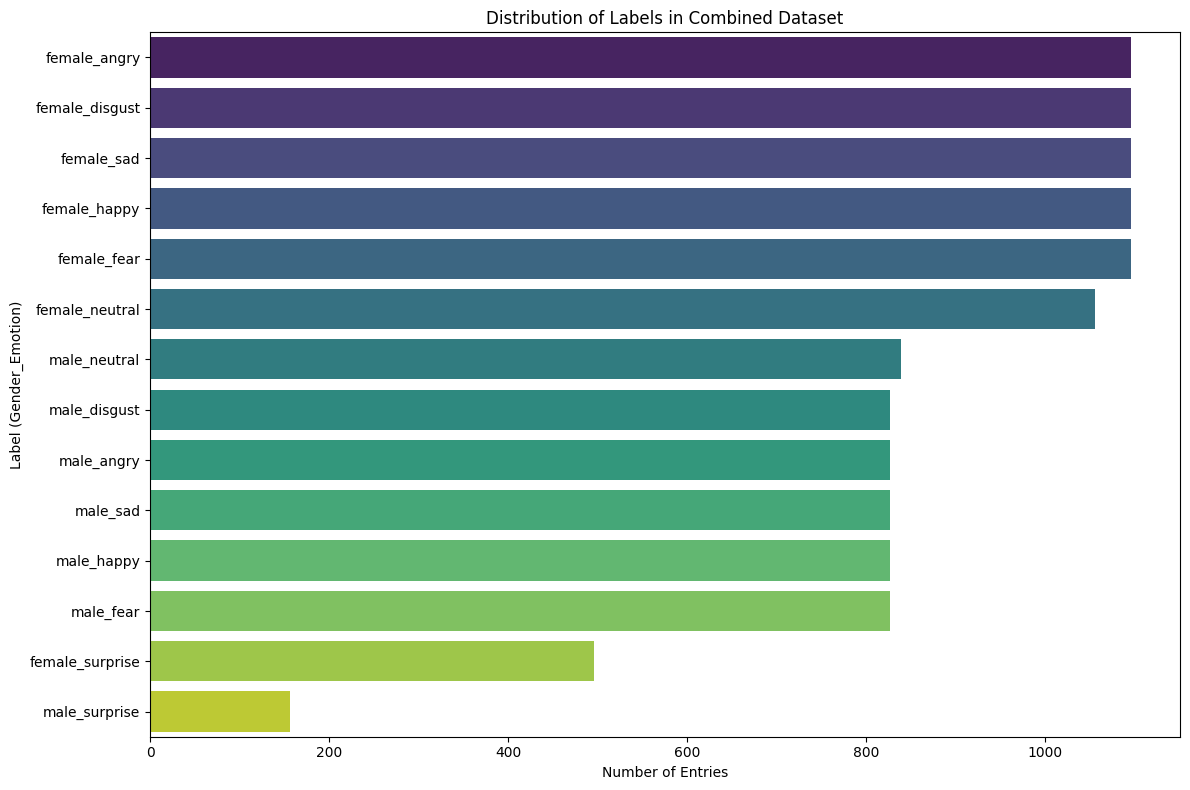

In [8]:

# Get the value counts of the labels in combined_df
label_counts = combined_df['labels'].value_counts().reset_index()
label_counts.columns = ['labels', 'count']

# Sort the labels for better visualization if needed, or keep as is
label_counts = label_counts.sort_values(by='count', ascending=False)

# Create a bar plot, addressing the FutureWarning
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='labels', data=label_counts, palette='viridis', hue='labels', legend=False)
plt.title('Distribution of Labels in Combined Dataset')
plt.xlabel('Number of Entries')
plt.ylabel('Label (Gender_Emotion)')
plt.tight_layout()
plt.show()

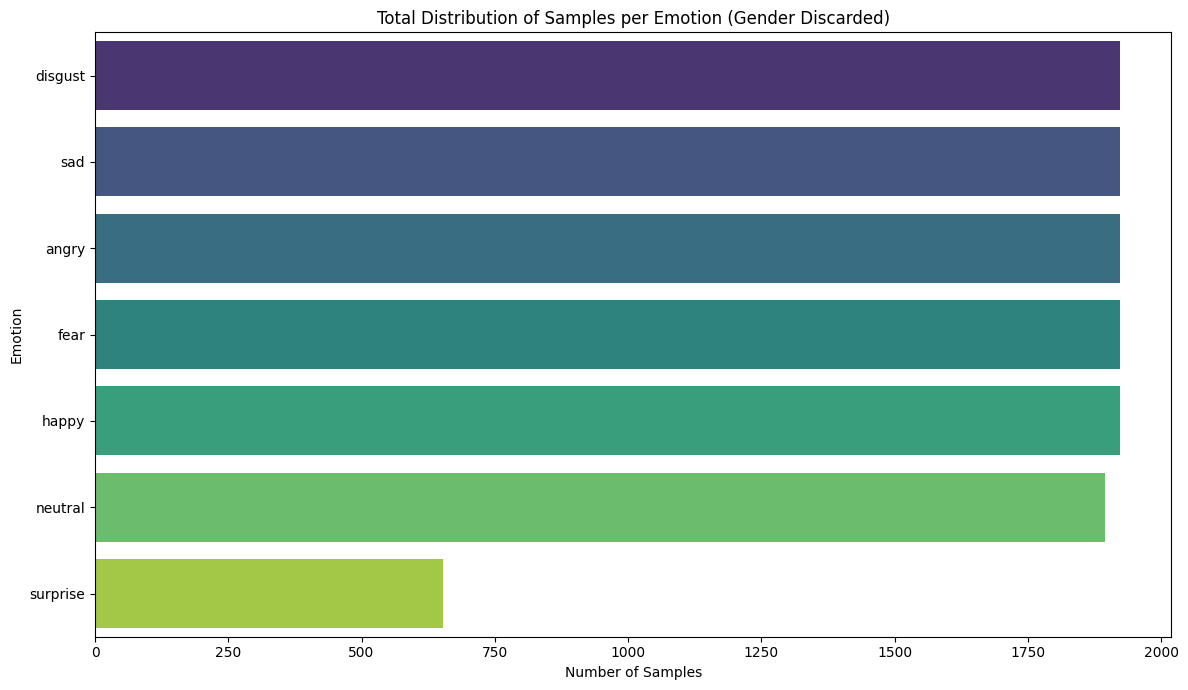

In [9]:
# Extract just the emotion from the 'labels' column
# This assumes labels are in 'gender_emotion' format
combined_df['emotion_only'] = combined_df['labels'].apply(lambda x: x.split('_')[1] if '_' in x else x)

# Get the value counts of the emotions
emotion_counts = combined_df['emotion_only'].value_counts().reset_index()
emotion_counts.columns = ['emotion', 'count']

# Sort the emotions for better visualization
emotion_counts = emotion_counts.sort_values(by='count', ascending=False)

# Create a bar plot for emotion distribution
plt.figure(figsize=(12, 7))
sns.barplot(x='count', y='emotion', data=emotion_counts, palette='viridis', hue='emotion', legend=False)
plt.title('Total Distribution of Samples per Emotion (Gender Discarded)')
plt.xlabel('Number of Samples')
plt.ylabel('Emotion')
plt.tight_layout()
plt.show()

# Drop the temporary 'emotion_only' column
combined_df = combined_df.drop(columns=['emotion_only'])


In [10]:
import pickle

# Get all unique labels from the combined_df
unique_labels = combined_df['labels'].unique()

# Create EMOTION_MAP
EMOTION_MAP = {label: i for i, label in enumerate(unique_labels)}
n_emotions = len(EMOTION_MAP)

print("EMOTION_MAP created:")
print(EMOTION_MAP)
print(f"Number of emotions (n_emotions): {n_emotions}")

# Ensure output_dir exists for saving class names
output_dir = './model_metadata'
os.makedirs(output_dir, exist_ok=True)

# Save EMOTION_MAP to a pickle file
with open(os.path.join(output_dir, 'class_names.pkl'), 'wb') as f:
    pickle.dump(EMOTION_MAP, f)

print("Lista de clases guardada como 'class_names.pkl' in model_metadata folder")
#Se guardarás mas metadatos en la función extract_mfccs

EMOTION_MAP created:
{'male_surprise': 0, 'male_disgust': 1, 'male_neutral': 2, 'male_angry': 3, 'male_sad': 4, 'male_fear': 5, 'male_happy': 6, 'female_fear': 7, 'female_angry': 8, 'female_surprise': 9, 'female_neutral': 10, 'female_sad': 11, 'female_happy': 12, 'female_disgust': 13}
Number of emotions (n_emotions): 14
Lista de clases guardada como 'class_names.pkl' in model_metadata folder


In [11]:
### --- CONSTANTES DE PREPROCESAMIENTO ---
# Frecuencia de muestreo (Sample Rate) - CONFIRMADO: 16kHz
SR = 16000
# Longitud del paso de ventana (Hop Length) ~10ms - CONFIRMADO: 160
HOP_LENGTH = 160
# Duración fija del segmento de audio (en segundos)
DURATION = 3.0
# Número total de características (13 MFCCs + Delta + Delta-Delta)
N_MFCC_BASE = 13
N_FEATURES = N_MFCC_BASE * 3
# Muestras totales por segmento (3 segundos * 16000 SR)
SAMPLES_PER_SEGMENT = SR * DURATION
# Número de pasos de tiempo (timesteps) para la RNN (ajustado por hop_length y SR)
N_TIMESTEPS = 297
SEED = 42

# Resumen de la configuración
print("--- Configuración de Preprocesamiento ---")
print(f"Frecuencia de Muestreo (SR): {SR} Hz")
print(f"Características por Timestep: {N_FEATURES} (13 MFCCs + Deltas)")
print(f"Timesteps para la RNN: {N_TIMESTEPS} (~3 segundos)")
print(f"Clases de Emoción detectadas: {n_emotions}")

--- Configuración de Preprocesamiento ---
Frecuencia de Muestreo (SR): 16000 Hz
Características por Timestep: 39 (13 MFCCs + Deltas)
Timesteps para la RNN: 297 (~3 segundos)
Clases de Emoción detectadas: 14


In [12]:

# Extracción de MFCCs con duración estandarizada
def extract_mfccs(audio_path: str) -> np.ndarray:
    """Carga audio, estandariza duración y extrae MFCCs (39)."""
    longitud_en_muestras = int(DURATION * SR)
    y, sr = librosa.load(audio_path, sr=SR)
    y_estandarizado = librosa.util.fix_length(y, size=longitud_en_muestras)
    mfccs = librosa.feature.mfcc(y=y_estandarizado, sr=SR, n_mfcc=N_MFCC_BASE, hop_length=HOP_LENGTH)
    mfccs_delta = librosa.feature.delta(mfccs)
    mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
    mfccs_completos = np.concatenate((mfccs, mfccs_delta, mfccs_delta2), axis=0)
    mfccs_fijo = librosa.util.fix_length(mfccs_completos, size=N_TIMESTEPS, axis=1)
    return mfccs_fijo.T 

# Normalización Z-Score Global
def z_score_normalize(X_train: np.ndarray, X_val: np.ndarray, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Calcula Z-Score solo con los datos de entrenamiento y lo aplica a todos."""
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    GLOBAL_MEAN = np.mean(X_train_flat, axis=0)
    GLOBAL_STD = np.std(X_train_flat, axis=0)
    GLOBAL_STD[GLOBAL_STD == 0] = 1e-6 

    # Opcional: Crear un directorio para los metadatos si no existe
    output_dir = './model_metadata'
    os.makedirs(output_dir, exist_ok=True)
    
    # Guardar la media en un archivo .npy
    np.save(os.path.join(output_dir, 'global_mean.npy'), GLOBAL_MEAN)
    
    # Guardar la desviación estándar en un archivo .npy
    np.save(os.path.join(output_dir, 'global_std.npy'), GLOBAL_STD)
    
    print(f"\nMetadatos de normalización guardados en: {output_dir}")

    X_train_norm = (X_train - GLOBAL_MEAN) / GLOBAL_STD
    X_val_norm = (X_val - GLOBAL_MEAN) / GLOBAL_STD
    X_test_norm = (X_test - GLOBAL_MEAN) / GLOBAL_STD
    
    return X_train_norm, X_val_norm, X_test_norm


In [ ]:

# 3.2. Carga, Extracción de MFCCs y Etiquetado desde combined_df
X_data = []
y_labels = []

print("Iniciando extracción de MFCCs y etiquetado desde combined_df...")

for index, row in combined_df.iterrows():
    audio_path = row['path']
    label_str = row['labels']

    try:
        mfccs_matrix = extract_mfccs(audio_path)
        if mfccs_matrix.shape == (N_TIMESTEPS, N_FEATURES):
            X_data.append(mfccs_matrix)
            y_labels.append(EMOTION_MAP[label_str])
        else:
            print(f"Alerta: {audio_path} tiene forma {mfccs_matrix.shape}, se ignora.")
    except Exception as e:
        print(f"Error al procesar {audio_path}: {e}")

X_data = np.array(X_data)
y_labels = np.array(y_labels)

# The class_names should represent the integer labels, which are the values of EMOTION_MAP
class_names = sorted(list(EMOTION_MAP.values()))

print("\n--- Resumen de Datos ---")
print(f"Número total de muestras cargadas: {X_data.shape[0]}")
print(f"Clases: {class_names}")

# 3.3. División de datos (Train, Val, Test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_data, y_labels, test_size=0.1, random_state=SEED, stratify=y_labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=(0.1/0.9), random_state=SEED, stratify=y_train_val
)

# 3.4. Normalización Z-Score Global
X_train_norm, X_val_norm, X_test_norm = z_score_normalize(X_train, X_val, X_test)

print("\n--- ¡PREPROCESAMIENTO COMPLETO! ---")
print(f"X_train_norm shape (Listo para RNN): {X_train_norm.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val_norm shape: {X_val_norm.shape}")
print(f"X_test_norm shape: {X_test_norm.shape}")
print(f"Número de clases: {len(class_names)}")

Iniciando extracción de MFCCs y etiquetado desde combined_df...


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.callbacks import ModelCheckpoint


# --- 1. Preparación Final de Etiquetas ---
# Las etiquetas 'y' están en formato entero (0 a 7), lo cual es ideal para Sparse Categorical Crossentropy,
# pero Keras funciona bien si están en one-hot para ciertos flujos o si se usa Categorical Crossentropy.
# Mantendremos el formato entero y usaremos 'sparse_categorical_crossentropy' por simplicidad.

# --- 2. Definir Parámetros de Entrenamiento ---
# Parámetros definidos en el preprocesamiento
N_TIMESTEPS = X_train_norm.shape[1] # 297
N_FEATURES = X_train_norm.shape[2]  # 39
NUM_CLASSES = len(class_names)      # 14
BATCH_SIZE = 64 # Mantener el batch size ligero para la RAM
EPOCHS = 200

# --- 3. Definir el Modelo (ARQUITECTURA HÍBRIDA CONV1D + BIDIRECTIONAL GRU) ---

# Input shape para la capa: (Timesteps, Características)
input_shape = (N_TIMESTEPS, N_FEATURES)

model = models.Sequential()

# Capa 1: Conv1D para extracción de características locales
model.add(layers.Conv1D(
    filters=64,
    kernel_size=5, # Common kernel size, can be tuned
    activation='relu',
    input_shape=input_shape,
    padding='same' # Keep the sequence length
))
model.add(layers.BatchNormalization()) # Stabilize training
model.add(layers.MaxPooling1D(pool_size=2)) # Reduce sequence length, helps GRU process longer sequences effectively
model.add(layers.Dropout(0.3))

# Capa 2: Bidirectional GRU para captura de contexto bidireccional
model.add(layers.Bidirectional(layers.GRU(
    units=64,
    return_sequences=True, # Pass full sequence to next GRU layer
    kernel_regularizer=tf.keras.regularizers.l2(0.001)
)))
model.add(layers.BatchNormalization()) # Stabilize training
model.add(layers.Dropout(0.3))

# Capa 3: Segunda Bidirectional GRU
model.add(layers.Bidirectional(layers.GRU(
    units=32,
    return_sequences=False, # Only return the last output for classification
    kernel_regularizer=tf.keras.regularizers.l2(0.001)
)))
model.add(layers.BatchNormalization()) # Stabilize training
model.add(layers.Dropout(0.3))

# Capa 4: Densa de clasificación
model.add(layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.BatchNormalization()) # Stabilize training
model.add(layers.Dropout(0.3))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# --- 4. Compilar el Modelo ---
model.compile(
    optimizer='adam',
    # Usamos sparse_categorical_crossentropy porque y_train es un array de enteros (0, 1, 2, ...)
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping (mejorado)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20, # Aumentar la paciencia para dar más oportunidad a la red para converger
    restore_best_weights=True
)
# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, # Reducir el LR a la mitad
    patience=7, # Si val_loss no mejora en 7 épocas, reduce LR
    min_lr=1e-6,
    verbose=1,
)

# Checkpoint directory and periodic saver (save every 5 epochs)
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_filepath = os.path.join(checkpoint_dir, 'modelo_ep_{epoch:02d}.keras')

class PeriodicSaver(tf.keras.callbacks.Callback):
    """Saves the full model every `period` epochs."""
    def __init__(self, filepath, period=5, save_weights_only=False):
        super().__init__()
        self.filepath = filepath
        self.period = period
        self.save_weights_only = save_weights_only

    def on_epoch_end(self, epoch, logs=None):
        # epoch is 0-indexed; save at epoch+1 multiples of period
        if (epoch + 1) % self.period == 0:
            filepath = self.filepath.format(epoch=epoch+1, **(logs or {}))
            # Save the whole model (architecture + weights + optimizer state)
            try:
                self.model.save(filepath)
                print(f'PeriodicSaver: saved model to {filepath}')
            except Exception as e:
                print(f'PeriodicSaver: failed to save model to {filepath}: {e}')

# Instantiate the periodic saver (every 5 epochs)
periodic_checkpoint = PeriodicSaver(filepath=checkpoint_filepath, period=5)

model.summary()

# --- 5. Entrenar el Modelo ---
print("\n--- Iniciando entrenamiento del modelo híbrido ---")

# Entrenar directamente sobre los arrays de NumPy ya preprocesados
history = model.fit(
    X_train_norm,
    y_train,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_norm, y_val),
    callbacks=[early_stop, lr_scheduler, periodic_checkpoint],
    epochs=EPOCHS,
)

print("\n--- Entrenamiento completado ---")

# --- 6. Evaluación y Métricas ---

# Obtener datos de la historia
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
actual_epochs = len(acc)
epochs_range = range(actual_epochs)

# Evaluar en el conjunto de prueba
print("\n--- Evaluando en conjunto de prueba ---")
test_loss, test_acc = model.evaluate(X_test_norm, y_test, verbose=0)

# Predicciones para métricas detalladas
test_predictions = model.predict(X_test_norm)
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Calcular métricas de clasificación (Precision, Recall, F1-score)
precision, recall, f1_score, _ = precision_recall_fscore_support(
    y_test,
    test_predicted_labels,
    average='weighted',
    zero_division=0,
)

print(f"\nPérdida en Test: {test_loss:.4f}")
print(f"Precisión en Test: {test_acc*100:.2f}%")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-score (Weighted): {f1_score:.4f}")


# --- 7. Visualización de Resultados ---

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión de Entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión de Validación')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida de Validación')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación')

plt.show()


In [ ]:
model.save('RNN-GRU-4ds.keras')